# Chapitre 8 : Statistiques avancées

### Analyses factorielles

In [2]:
# Chargement des bibliothèques
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Chargement et mise en forme des données
tableau = pd.read_csv("./data/base-pop-2015-communes.csv")
tab_num = tableau.drop(["CODGEO","REG",
                "DEP","LIBGEO","P15_POP"],axis=1)
tab_norm = StandardScaler().fit_transform(tab_num)

# Application de l'ACP
pca = PCA(n_components=3)
decomposition = pca.fit_transform(tab_norm)

# Mise en forme et affichage
decomposition = pd.DataFrame(data = decomposition,
       columns = ['facteur 1', 'facteur 2', 'facteur 3'])
decomposition.head()


,facteur 1,facteur 2,facteur 3
0,-0.677155,0.306759,0.383459
1,-1.146110,-1.271362,-0.034671
2,8.578975,0.284749,-4.194704
3,-0.242592,-0.786465,-0.241956
4,-1.222772,-1.264867,-0.054123


In [3]:
print([round(i,2) for i in pca.explained_variance_ratio_])

[0.87, 0.04, 0.03]


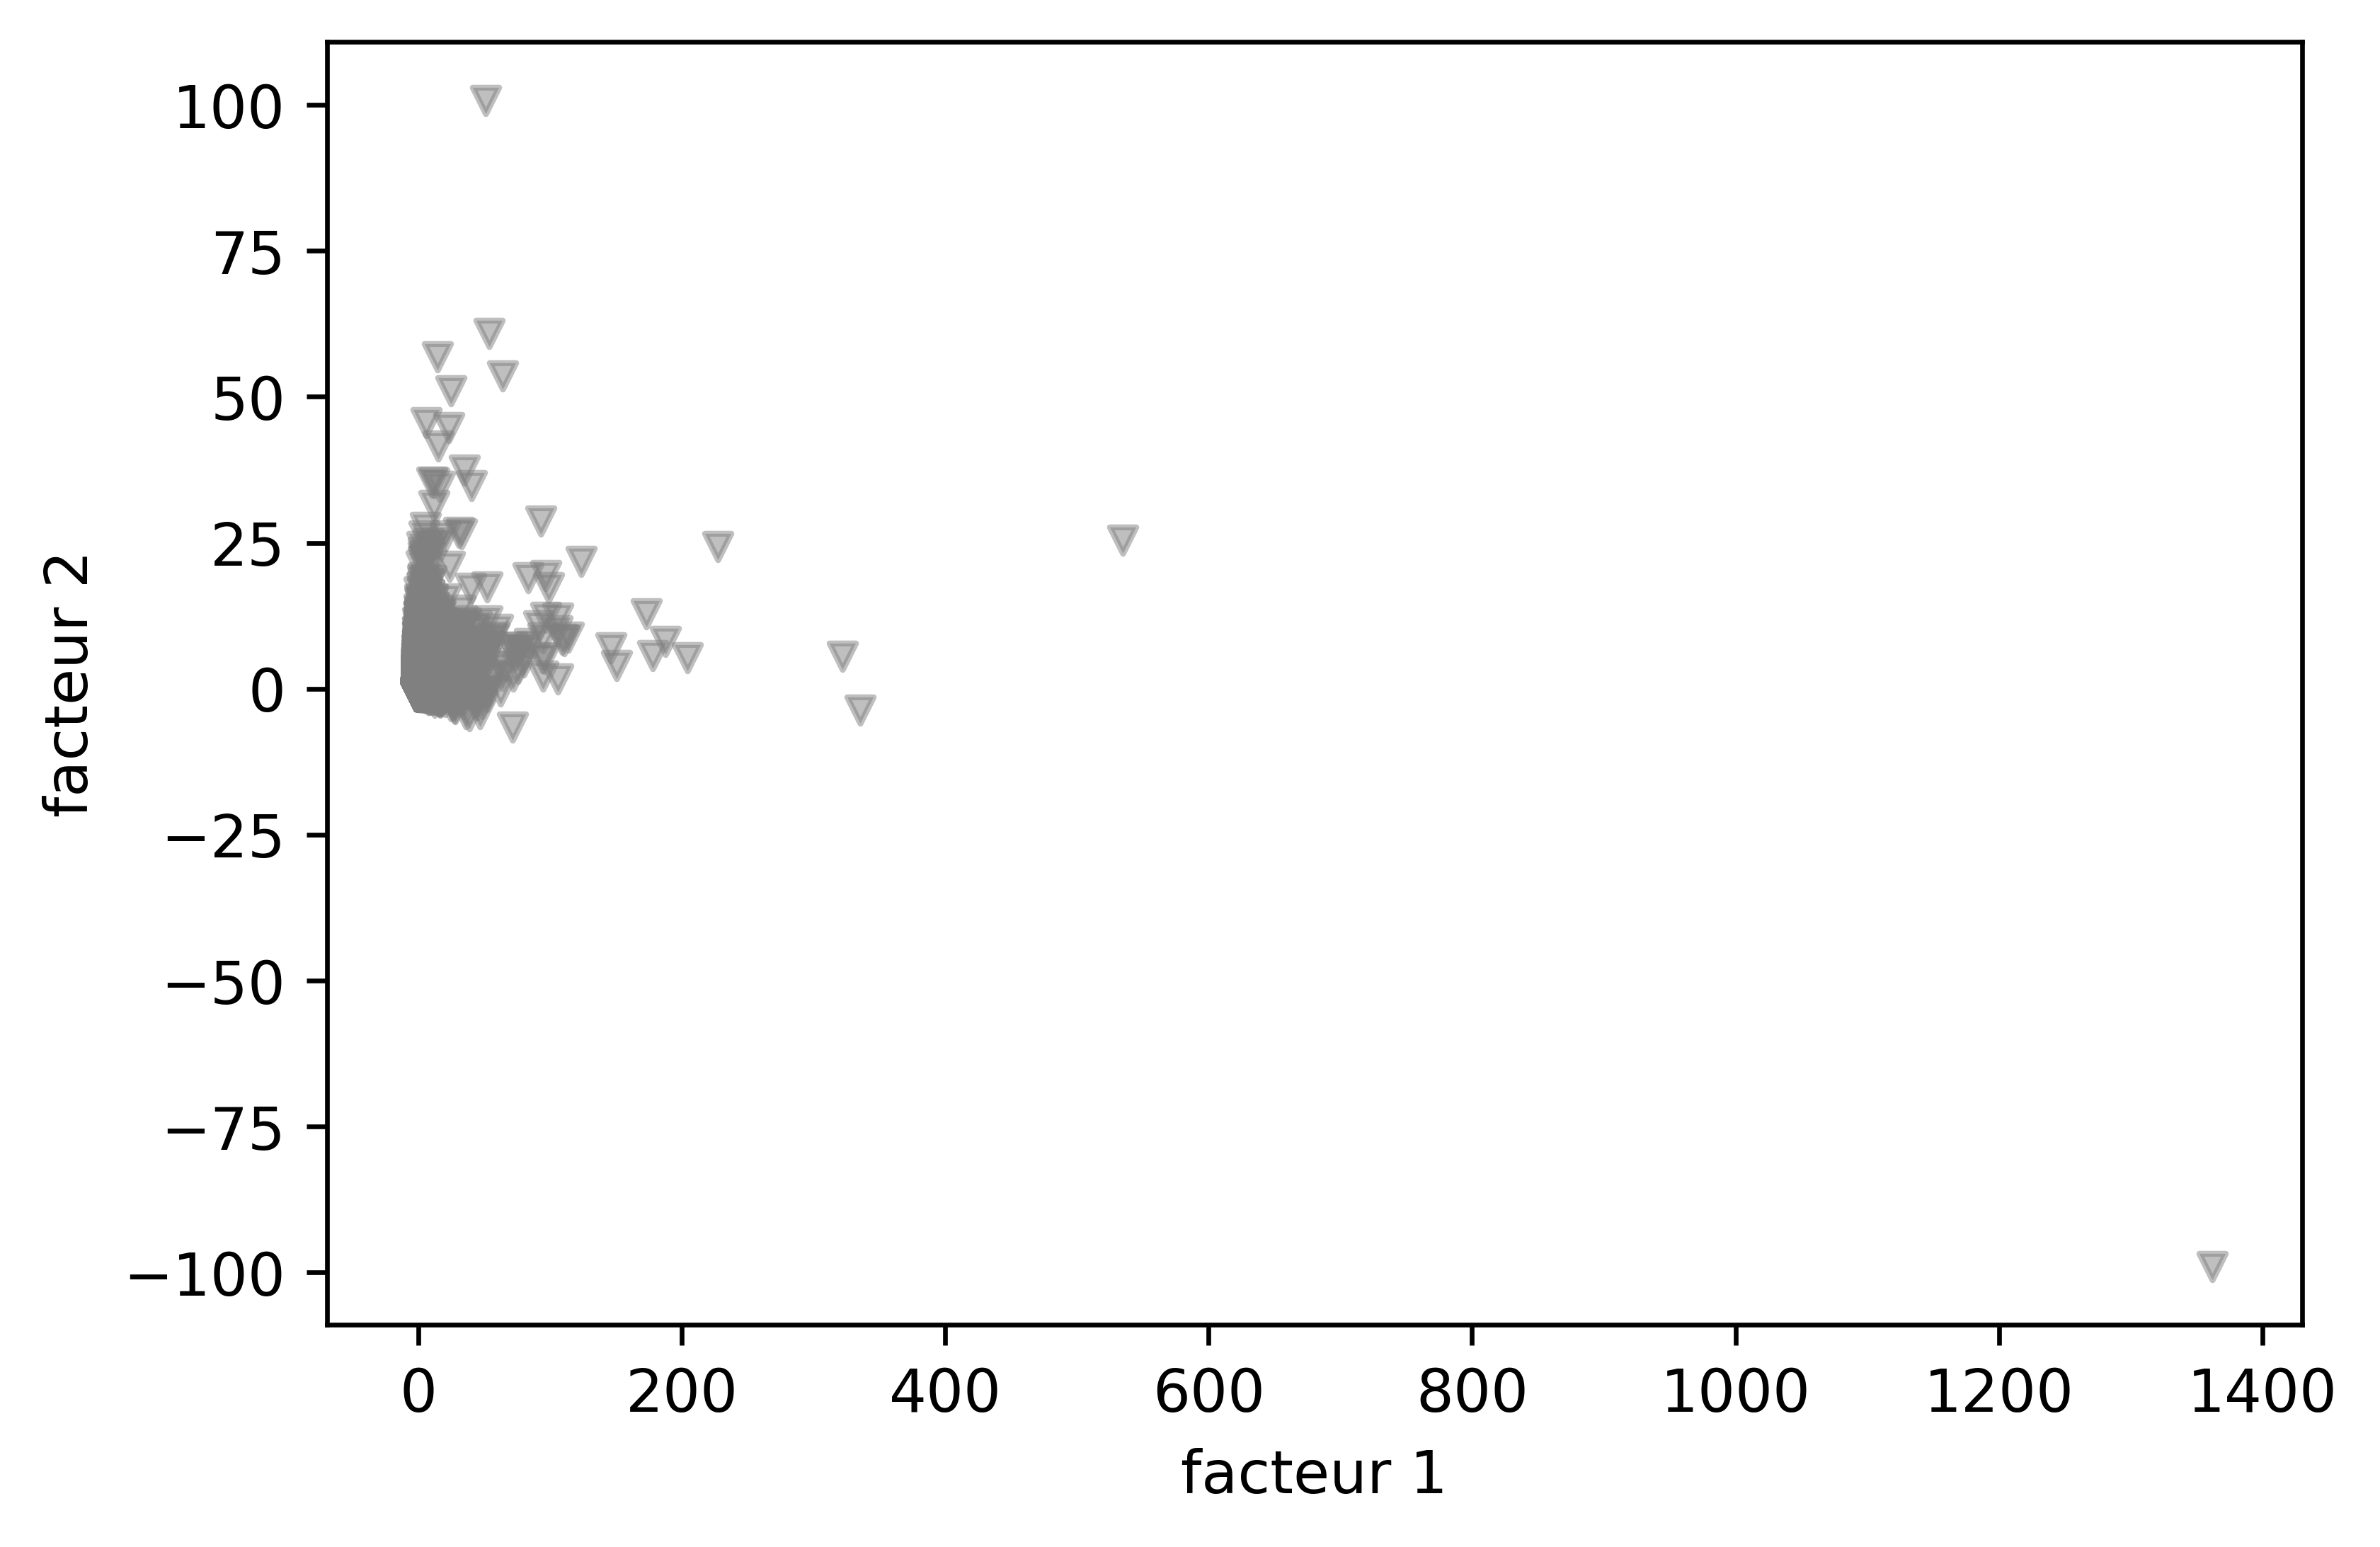

In [4]:
ax = decomposition.plot(kind="scatter",color="gray", alpha=0.5,
                        x='facteur 1',y='facteur 2', marker = "v")

In [5]:
tableau[decomposition["facteur 1"]>400]["LIBGEO"]

4385     Marseille
29631        Paris
Name: LIBGEO, dtype: object

In [6]:
d2 = (tab_norm**2).sum(axis=1)
cos2 = decomposition**2
cos2["d2"]= d2
cos2 = cos2.apply(lambda x : x/x["d2"],axis=1)
cos2 = cos2.drop("d2",axis=1)
cos2.head()

,facteur 1,facteur 2,facteur 3
0,0.103090,0.021156,0.033058
1,0.220244,0.271013,0.000202
2,0.708399,0.000780,0.169360
3,0.014261,0.149880,0.014186
4,0.244118,0.261215,0.000478


In [7]:
import prince

# Application du modèle
pca = prince.PCA(n_components=3,
                 rescale_with_mean=True,
                 rescale_with_std=True)
pca = pca.fit(tab_num.values)
decomposition = pca.transform(tab_num.values)

# Affichage de paramètres
print([round(i,2) for i in pca.explained_inertia_])

[0.87, 0.04, 0.03]


In [8]:
import prince

# Chargement et mise en forme des données
tableau = pd.read_csv("./data/data-chap6.csv")
colonnes = ["P15_POP_C","prop_f_C",
            "prop_sup75_C","prop_ouvriers_C"]
X = tableau[tableau["DEP"]=="67"][colonnes]

# Application de l'ACM
acm = prince.MCA(n_components=2)
acm = acm.fit(X)

# Affichage
print([round(i,3) for i in acm.explained_inertia_])

[0.134, 0.113]


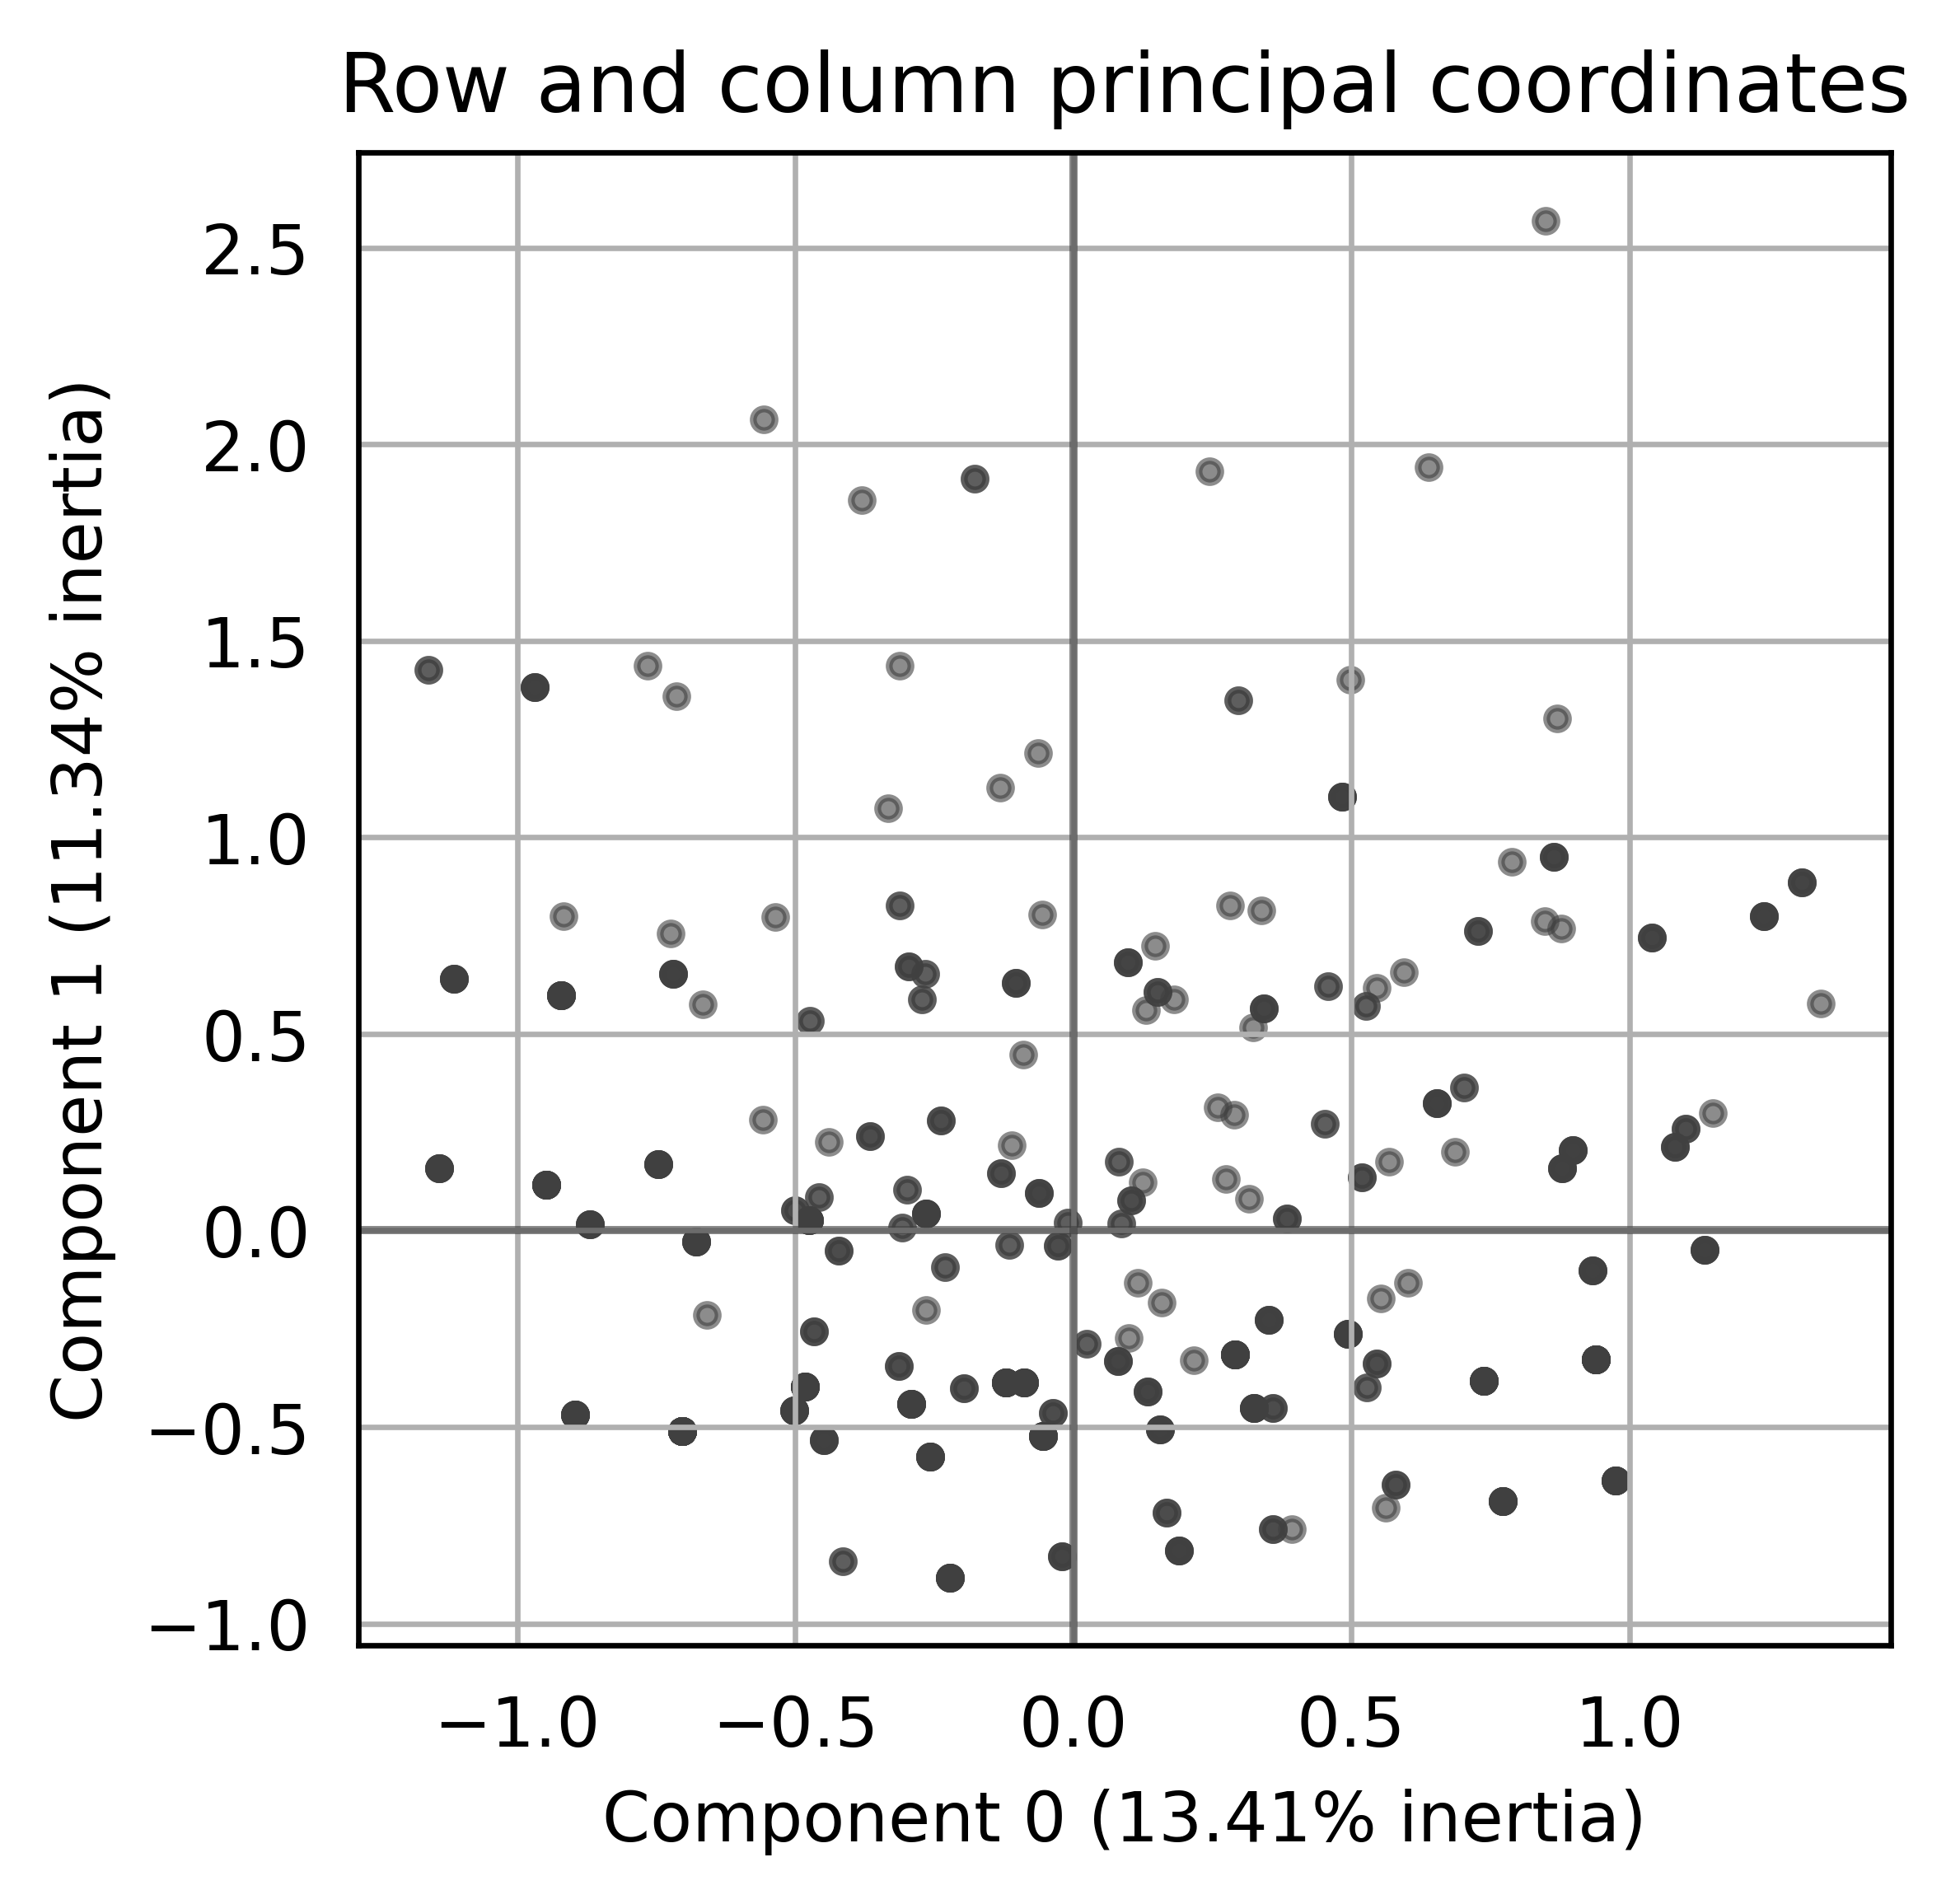

In [9]:
X.columns = [i.replace("_","") for i in X.columns]
ax = acm.plot_coordinates(X=X, figsize=(4, 4),
                          row_points_size=10,
                          show_row_labels=False,
                          show_column_points=False,
                          column_points_size=30,
                          show_column_labels=False)
ax.get_figure().savefig('mca.svg')

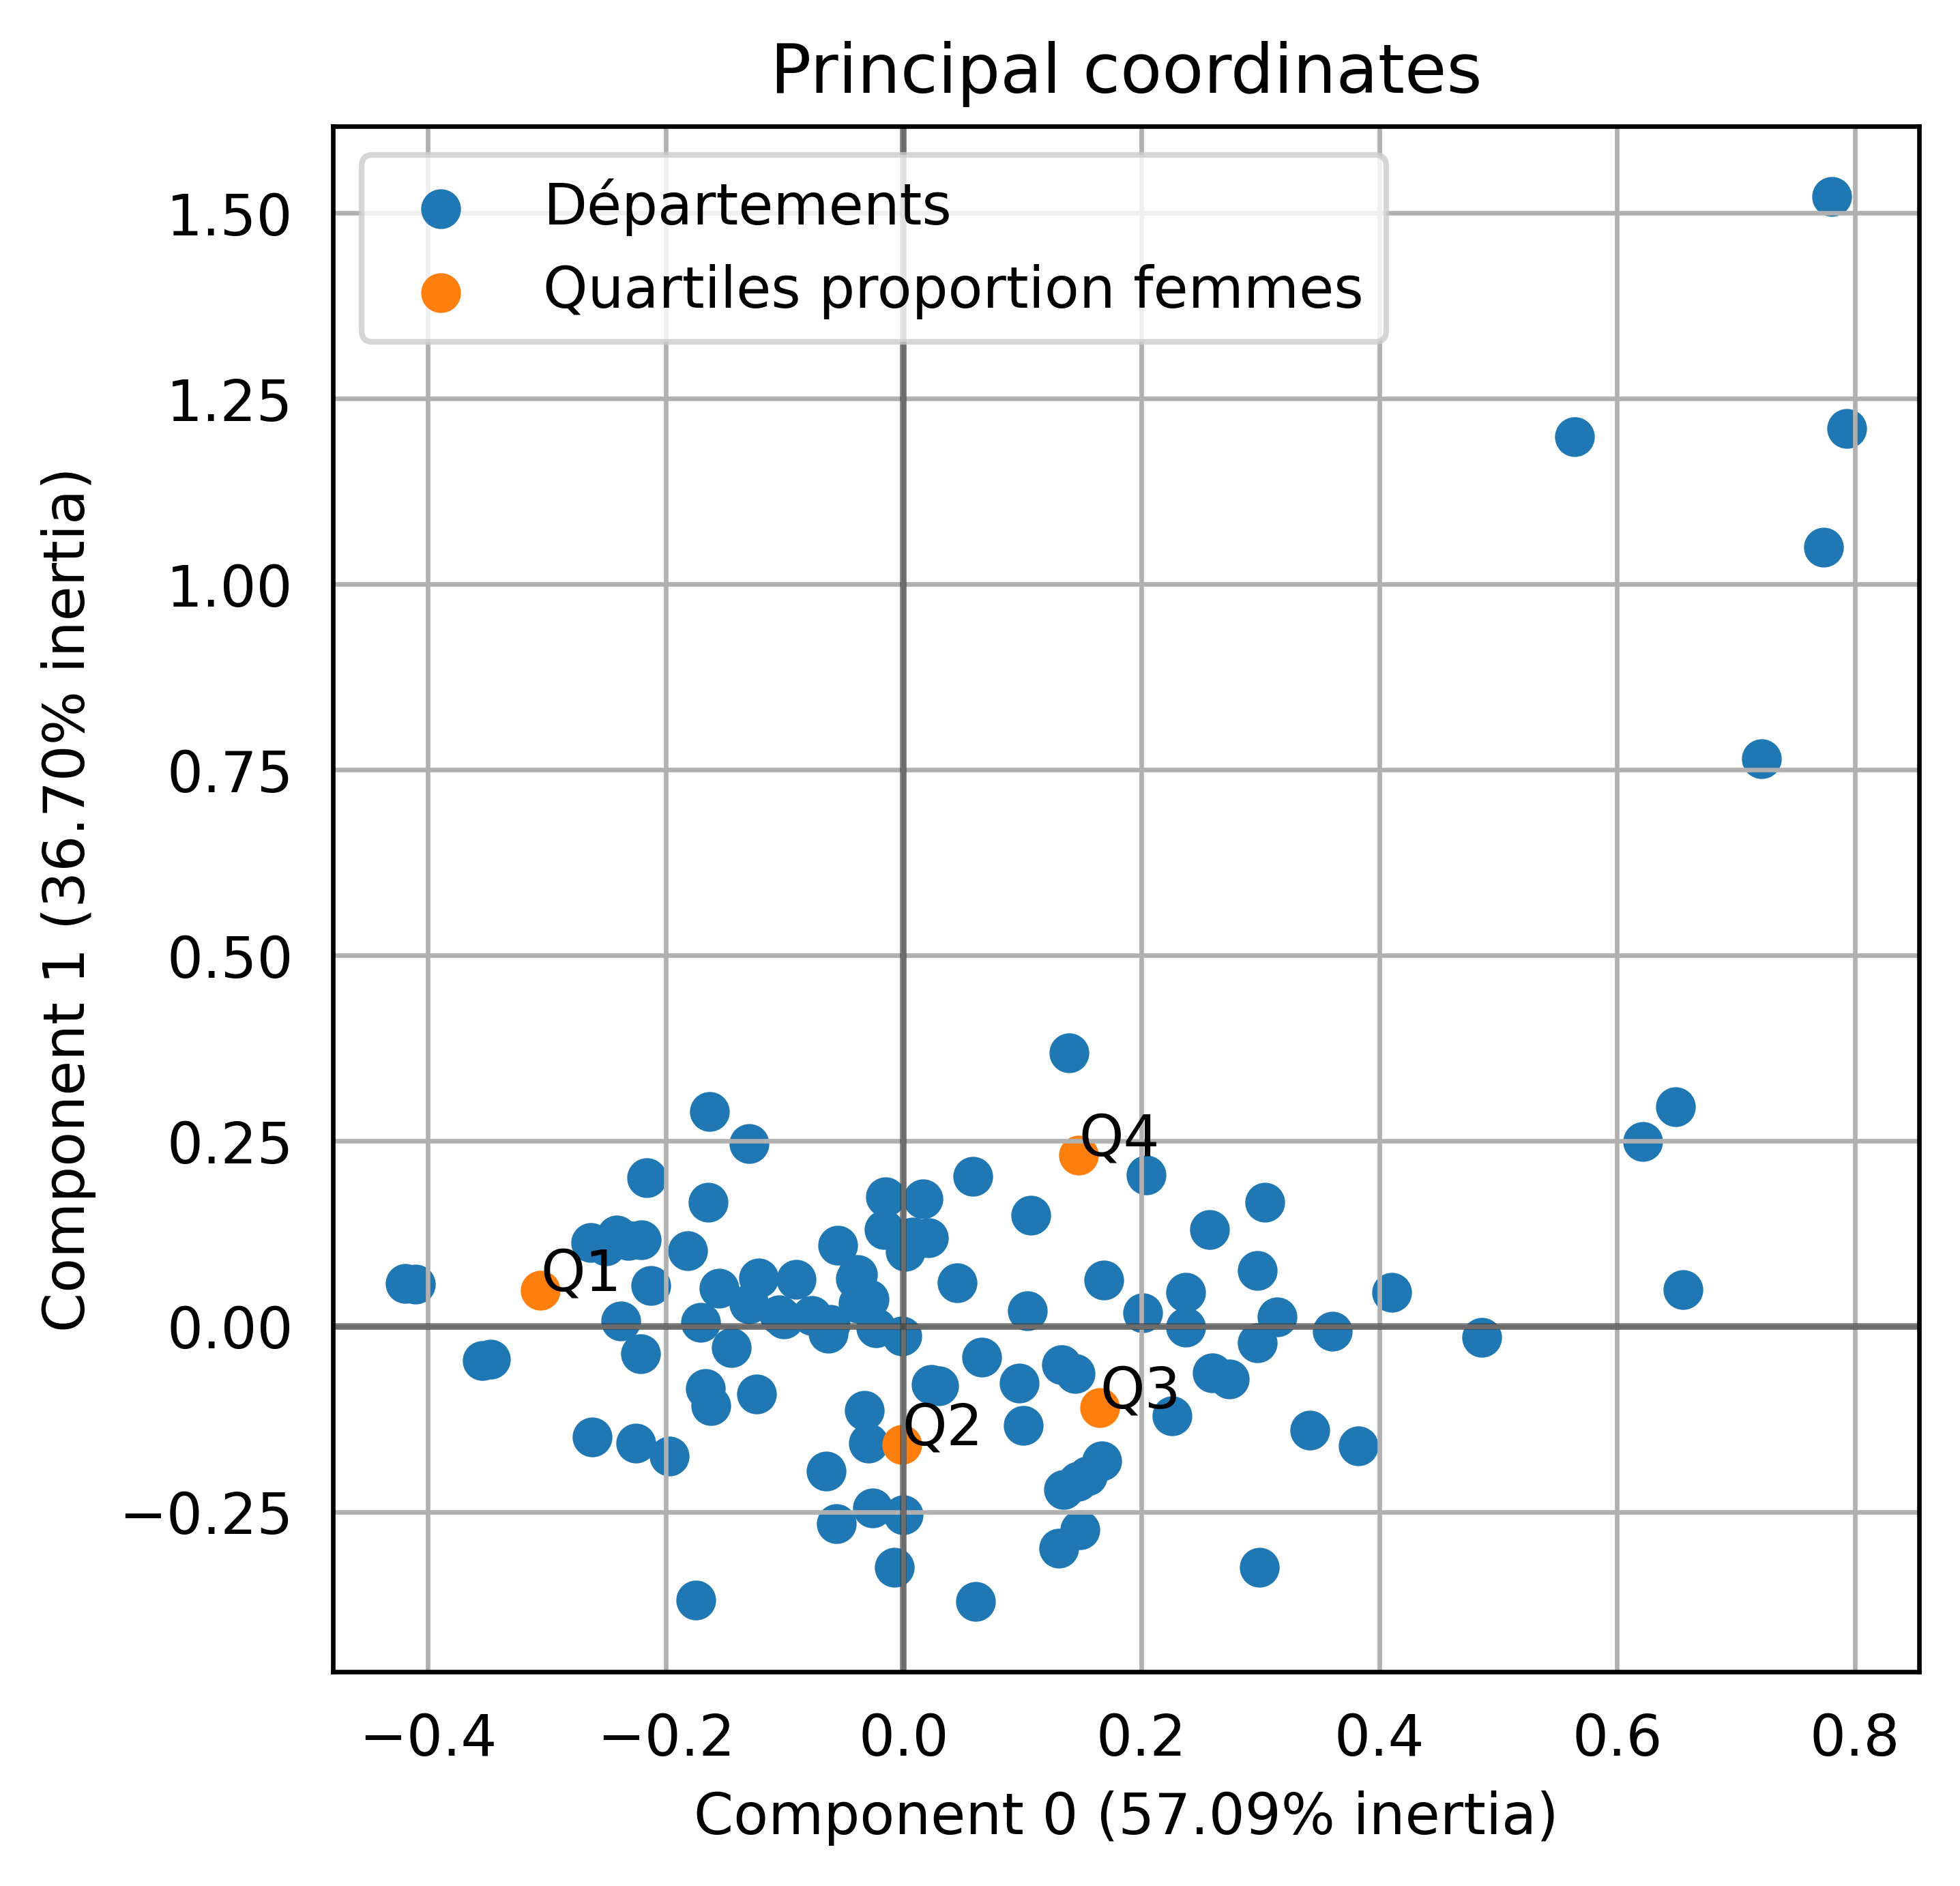

In [10]:
import prince

# Chargement et mise en forme des données
X = pd.crosstab(tableau["DEP"], tableau["prop_f_C"])
X.columns.rename('Quartiles proportion femmes', inplace=True)
X.index.rename('Départements', inplace=True)

# Application de l'AFC
afc = prince.CA(n_components=2)
afc = afc.fit(X)

# Affichage
afc = afc.plot_coordinates(X=X, figsize=(5, 5),
                          show_row_labels=False,
                          x_component=0, y_component=1)

### Régressions linéaire et logistique

In [11]:
import statsmodels.api as sm

# Chargement et mise en forme des données
donnees = tableau[["prop_ouvriers","prop_sup75",
                "P15_POP","prop_f"]].dropna()
X = donnees[["prop_ouvriers","prop_sup75", "P15_POP"]]
Y = donnees["prop_f"]

# Appliquer la régression
modele = sm.OLS(Y,X)
regression = modele.fit()

# Affichage
print('Paramètres: ', regression.params)
print('R2: ', round(regression.rsquared,2))

Paramètres:  prop_ouvriers    1.761921
prop_sup75       2.396768
P15_POP          0.000093
dtype: float64
R2:  0.91


In [12]:
import statsmodels.api as sm
from patsy import dmatrices

# Mise en forme des données
tableau["prop_f_dich"] = pd.qcut(tableau["prop_f"],
                            [0,0.5,1],[0,1])
tab_reg = tableau[["prop_f_dich", "prop_ouvriers_C",
                    "prop_sup75_C", "P15_POP_C"]].dropna()

# Création des variables dépendantes et indépendantes
y, X = dmatrices(
    'prop_f_dich~C(prop_ouvriers_C)+C(prop_sup75_C)+C(P15_POP_C)', 
    tab_reg, return_type="dataframe")
y = y[y.columns[1]]

# Application de la régression
modele = sm.Logit(y,X)
regression = modele.fit()

# Affichage
print(regression.pvalues)

Optimization terminated successfully.
         Current function value: 0.625686
         Iterations 5
Intercept                   7.396532e-153
C(prop_ouvriers_C)[T.Q2]     3.574940e-03
C(prop_ouvriers_C)[T.Q3]     7.968558e-14
C(prop_ouvriers_C)[T.Q4]     2.311467e-45
C(prop_sup75_C)[T.Q2]        3.492900e-25
C(prop_sup75_C)[T.Q3]        5.644946e-82
C(prop_sup75_C)[T.Q4]       5.653602e-184
C(P15_POP_C)[T.Q2]           5.633297e-16
C(P15_POP_C)[T.Q3]           6.912931e-73
C(P15_POP_C)[T.Q4]           0.000000e+00
dtype: float64


In [13]:
X = pd.get_dummies(tab_reg[["prop_ouvriers_C", "prop_sup75_C", "P15_POP_C"]])
X["Intercept"]=1
X = X[[i for i in X.columns if not "Q1" in i]]
y = tab_reg["prop_f_dich"]

In [14]:
import numpy as np

df = np.exp(regression.conf_int())
df['odd ratio'] = round(np.exp(regression.params), 2)
df["p-value"] = round(regression.pvalues, 2)
df["IC"] = df.apply(lambda x : "%.2f [%.2f-%.2f]" \
                     % (x["odd ratio"],x[0],x[1]),axis=1)
df = df.drop([0,1], axis=1)
df

,odd ratio,p-value,IC
Intercept,0.39,0.0,0.39 [0.36-0.42]
C(prop_ouvriers_C)[T.Q2],0.91,0.0,0.91 [0.85-0.97]
C(prop_ouvriers_C)[T.Q3],0.79,0.0,0.79 [0.74-0.84]
C(prop_ouvriers_C)[T.Q4],0.63,0.0,0.63 [0.59-0.67]
C(prop_sup75_C)[T.Q2],1.40,0.0,1.40 [1.31-1.49]
C(prop_sup75_C)[T.Q3],1.85,0.0,1.85 [1.74-1.97]
C(prop_sup75_C)[T.Q4],2.60,0.0,2.60 [2.44-2.77]
C(P15_POP_C)[T.Q2],1.30,0.0,1.30 [1.22-1.38]
C(P15_POP_C)[T.Q3],1.80,0.0,1.80 [1.69-1.92]
C(P15_POP_C)[T.Q4],6.09,0.0,6.09 [5.68-6.52]


### Clustering

In [15]:
from sklearn.cluster import KMeans

# Sélection des données
tableau_cluster = tableau[["prop_f","prop_ouvriers",
                  "prop_sup75","P15_POP"]].dropna()

# Application de la classification
kmeans = KMeans(n_clusters=3)
kmeans.fit(tableau_cluster)

# Mise en forme et affichage
moyennes_groupes = pd.DataFrame(kmeans.cluster_centers_)
moyennes_groupes.columns = tableau_cluster.columns
moyennes_groupes

,prop_f,prop_ouvriers,prop_sup75,P15_POP
0,49.948335,12.221431,9.922526,1.586375e+03
1,52.900000,3.900000,7.700000,2.206488e+06
2,52.358537,8.546341,8.280488,1.927769e+05


In [16]:
pd.Series(kmeans.labels_).value_counts()

0    35351
2       41
1        1
dtype: int64

In [17]:
from scipy.cluster.hierarchy import linkage

tableau_cluster = tableau[["prop_f","prop_ouvriers",
    "prop_sup75","P15_POP"]].dropna().sample(n=1000)

arbre_associations = linkage(tableau_cluster.values, 'ward')

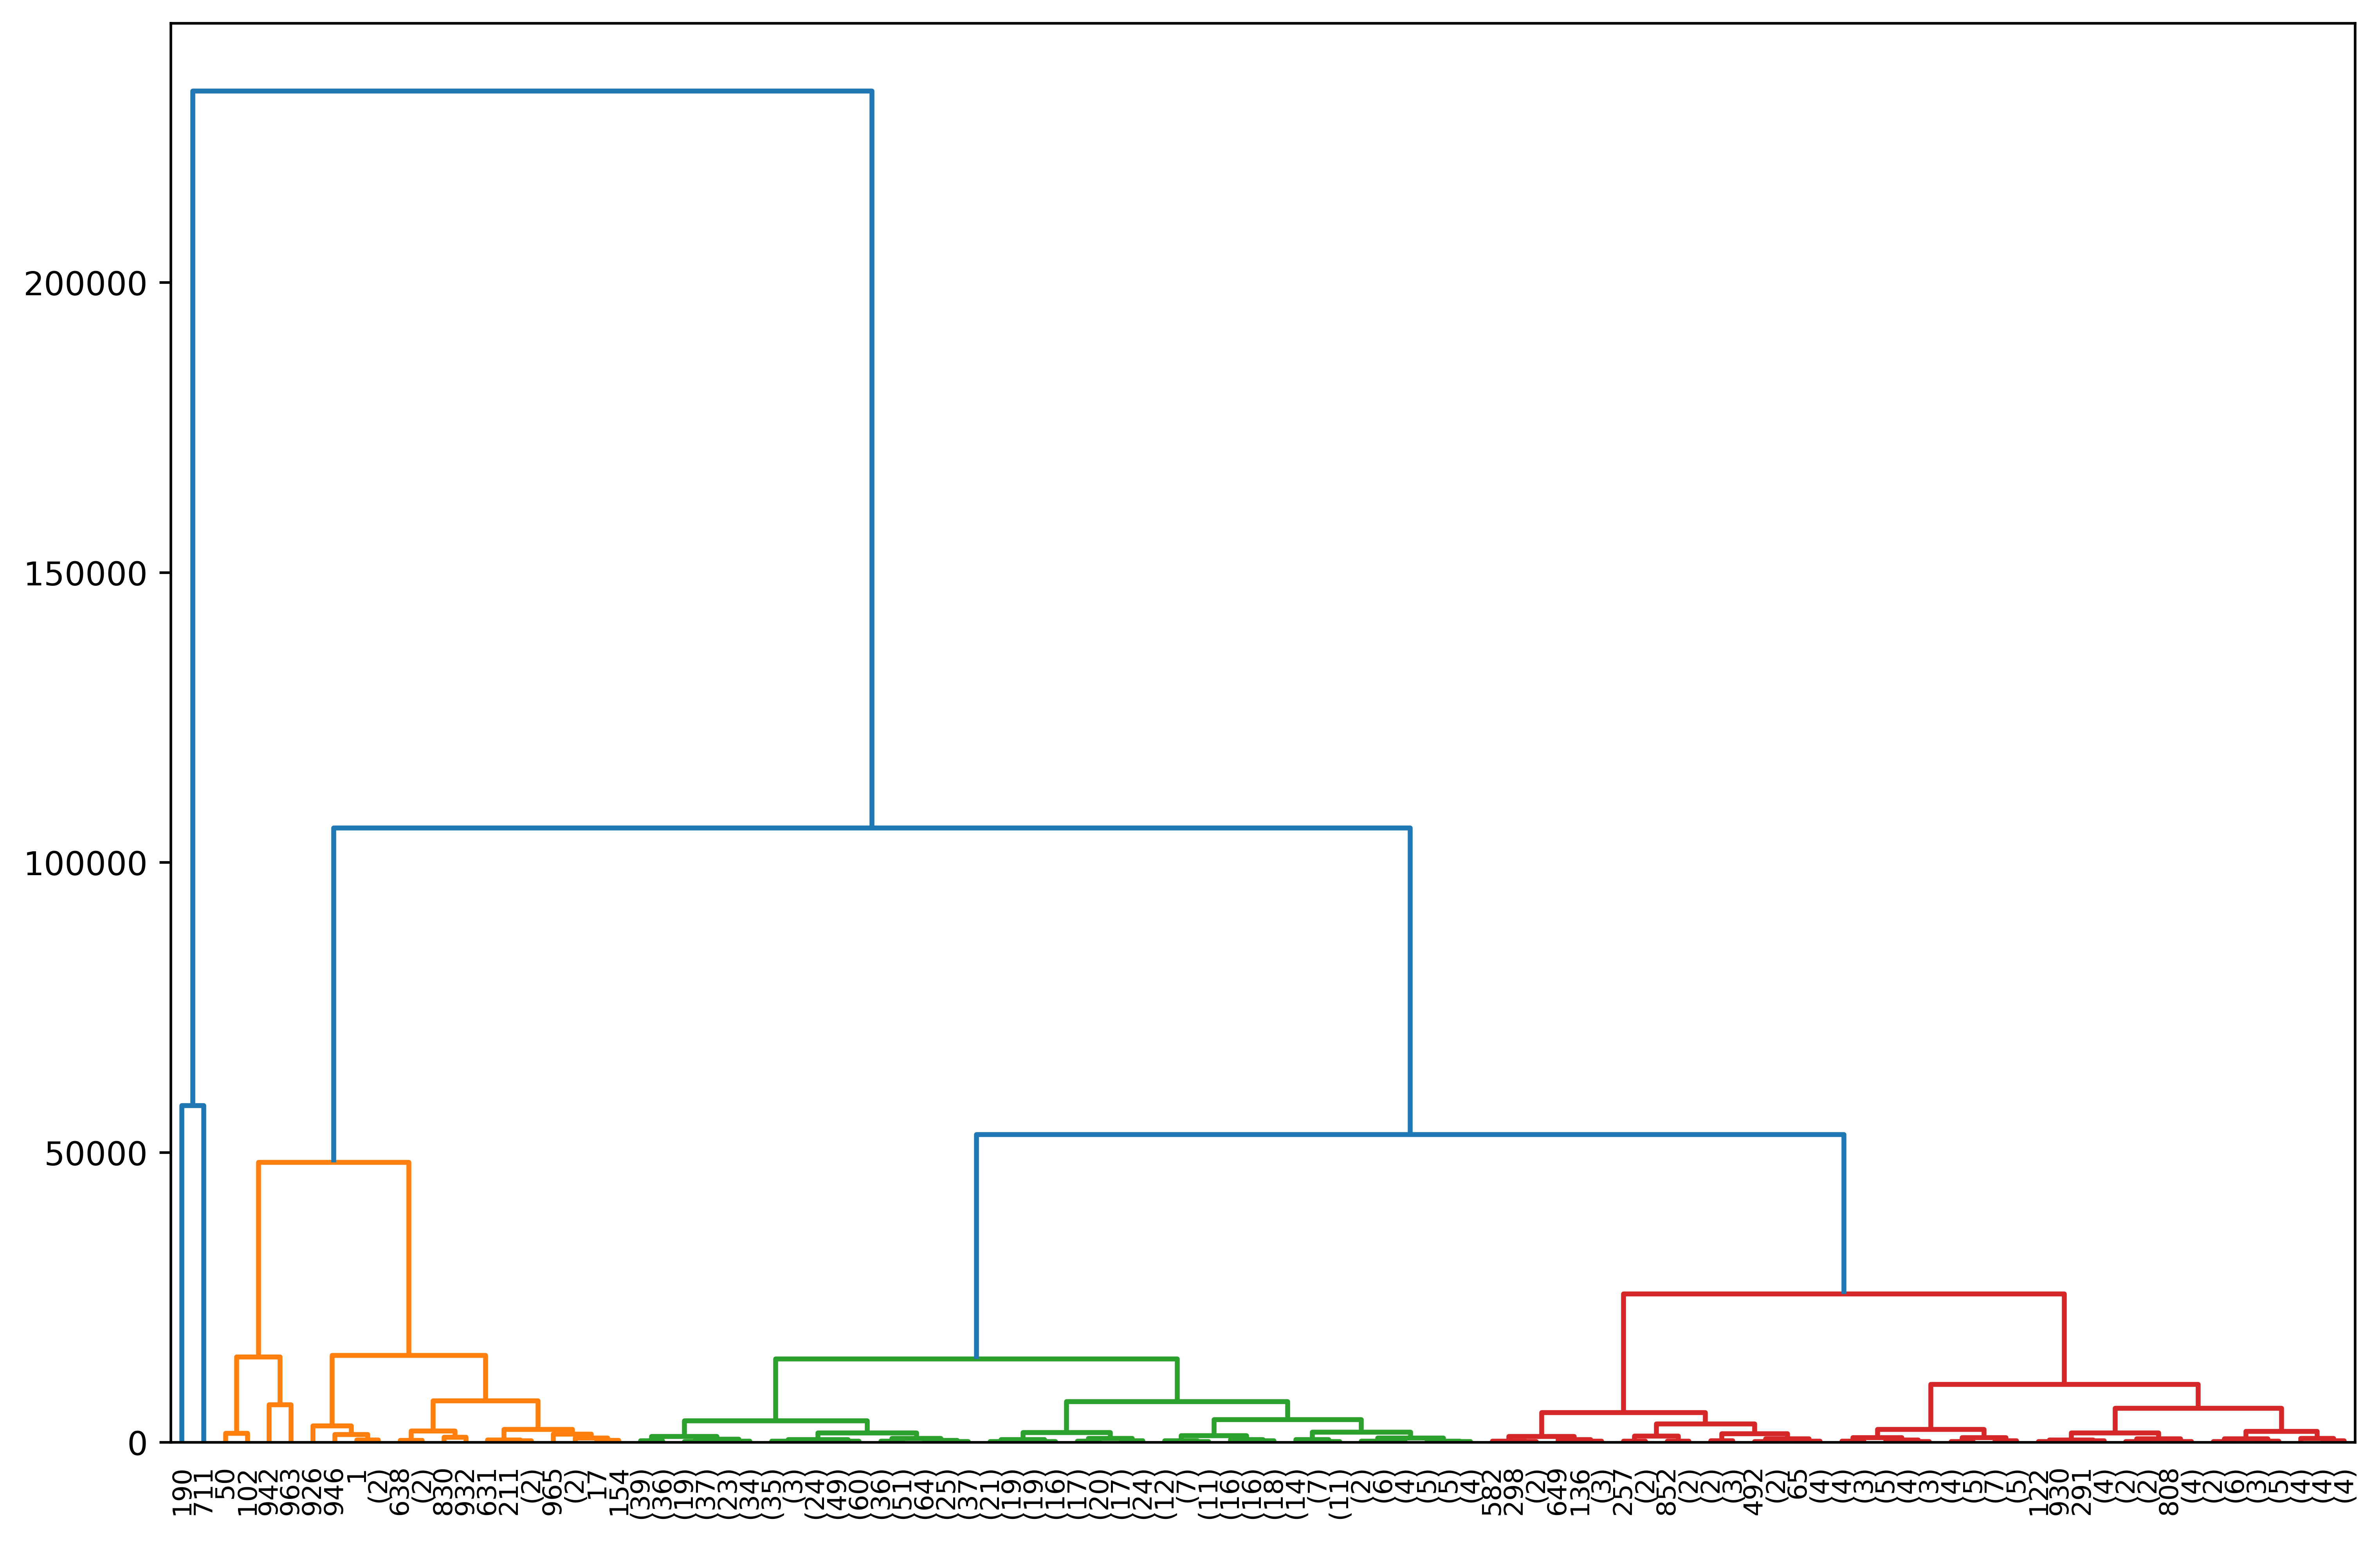

In [18]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
dendrogram(arbre_associations, distance_sort='ascending',
           truncate_mode = 'lastp', p=100, 
           color_threshold = 50000, leaf_rotation=90., 
           leaf_font_size=8., ax=ax)
fig.set_figwidth(12)
fig.set_figheight(8)

In [19]:
from scipy.cluster.hierarchy import fcluster
distance = 50000
clusters = fcluster(arbre_associations, distance,
            criterion='distance')
pd.Series(clusters).value_counts()

4    863
5    112
3     23
2      1
1      1
dtype: int64

In [20]:
tableau_cluster["cluster"] = clusters
tableau_cluster.groupby("cluster")["prop_f"].agg(["mean",
                                            "std","count"])

,mean,std,count
cluster,,,
1,53.400000,NaN,1
2,52.000000,NaN,1
3,51.834783,1.938746,23
4,49.648088,2.736747,863
5,51.483036,1.487781,112


### Machine learning

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Chargement des données et mise en forme
tableau_totales = tableau[["prop_f_dich","prop_ouvriers_C",
                      "prop_sup75_C","P15_POP_C"]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    tableau_totales[["prop_ouvriers_C",
                     "prop_sup75_C","P15_POP_C"]],
    tableau_totales['prop_f_dich'], test_size=0.20)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Application du modèle
modele_logistique = LogisticRegression()
modele_logistique.fit(X_train.values, y_train.values)
prediction = modele_logistique.predict(X_test)

# Affichage des résultats
score = modele_logistique.score(X_test, y_test)
print(round(score,2))

0.65
